In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from keras.models import Sequential
from keras.layers import *
from keras.optimizers.legacy import Adam
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression

sns.set_theme(rc={'figure.figsize':(16,8)})

def plot_confusion_matrix(Y_test, predicted):
    predicted = tf.squeeze(predicted)
    predicted = np.array([1 if x >= 0.5 else 0 for x in predicted])
    actual = np.array(Y_test)
    conf_mat = confusion_matrix(actual, predicted)
    displ = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
    displ.plot()


def my_read_data(scale=False):
    # Reads already cleaned data from .csv, scales if specified and returns X, Y values.

    file_path = Path('adults_data','adult_cleaned_data.csv')
    df = pd.read_csv(file_path)

    df = df.dropna()

    X = df.iloc[:,:-1]
    X = pd.get_dummies(X, dtype=float)
    Y = df.iloc[:,-1]

    if scale: pass

    return X, Y


def balance_data_ros(X_train, Y_train):
    ros = RandomOverSampler(random_state=0)
    return ros.fit_resample(X_train, Y_train)

* scaling
* train test split
* oversampling

In [26]:
def classification_rnn(epochs=200, batch_size=30, scale=True):

    X, Y = my_read_data(scale)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=45)

    # Build
    model = Sequential()
    model.add(Dense(64, "relu", input_shape=(66,)))
    model.add(Dense(16, "relu"))
    model.add(Dense(1, 'sigmoid'))

    # Compile 
    model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer=Adam())
    model.summary()

    # Fit & Predict
    model_fit = model.fit(X_train, Y_train, validation_split=0.15, batch_size=batch_size, epochs=epochs, verbose=True)    
    predicted = model.predict(X_test)

    # Get accuracy
    train_accuracy = model_fit.history['accuracy']
    val_accuracy = model_fit.history['val_accuracy']

    # Plot accuracy
    epochs = range(1, len(train_accuracy) + 1)
    plt.ylim(0,1)
    plt.plot(epochs, train_accuracy, label="Training set")
    plt.plot(epochs, val_accuracy, label="Validation set")
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

In [16]:
classification_rnn()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 64)                4288      
                                                                 
 dense_10 (Dense)            (None, 16)                1040      
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 5345 (20.88 KB)
Trainable params: 5345 (20.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200


UnimplementedError: Graph execution error:

Detected at node binary_crossentropy/Cast defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\mateu\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\mateu\AppData\Roaming\Python\Python311\site-packages\traitlets\config\application.py", line 1053, in launch_instance

  File "C:\Users\mateu\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelapp.py", line 737, in start

  File "C:\Users\mateu\AppData\Roaming\Python\Python311\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "c:\Users\mateu\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 607, in run_forever

  File "c:\Users\mateu\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "c:\Users\mateu\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\mateu\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 524, in dispatch_queue

  File "C:\Users\mateu\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 513, in process_one

  File "C:\Users\mateu\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 418, in dispatch_shell

  File "C:\Users\mateu\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 758, in execute_request

  File "C:\Users\mateu\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 426, in do_execute

  File "C:\Users\mateu\AppData\Roaming\Python\Python311\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\mateu\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3046, in run_cell

  File "C:\Users\mateu\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3101, in _run_cell

  File "C:\Users\mateu\AppData\Roaming\Python\Python311\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\mateu\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3306, in run_cell_async

  File "C:\Users\mateu\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3488, in run_ast_nodes

  File "C:\Users\mateu\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3548, in run_code

  File "C:\Users\mateu\AppData\Local\Temp\ipykernel_15276\451043146.py", line 1, in <module>

  File "C:\Users\mateu\AppData\Local\Temp\ipykernel_15276\1662360438.py", line 17, in main

  File "c:\Users\mateu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\mateu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1807, in fit

  File "c:\Users\mateu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function

  File "c:\Users\mateu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function

  File "c:\Users\mateu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step

  File "c:\Users\mateu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1151, in train_step

  File "c:\Users\mateu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1209, in compute_loss

  File "c:\Users\mateu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__

  File "c:\Users\mateu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 143, in __call__

  File "c:\Users\mateu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 270, in call

  File "c:\Users\mateu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 2521, in binary_crossentropy

Cast string to float is not supported
	 [[{{node binary_crossentropy/Cast}}]] [Op:__inference_train_function_2415]

In [19]:
def classification_lr(scale=False, balance=False):
    
    X, Y = my_read_data(scale)

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=45)

    if balance: 
        X_train, Y_train = balance_data_ros(X_train, Y_train)

    clf = LogisticRegression().fit(X_train, Y_train)
    y_pred = clf.predict(X_test)
    classif_rep_im = classification_report(Y_test, y_pred)
    print(f'Accuracy imbalanced {accuracy_score(Y_test, y_pred):.2f}')
    print("\nClassification report for imbalanced data\n", classif_rep_im)
    cm_im = ConfusionMatrixDisplay.from_estimator(clf, X_test, Y_test) 
    cm_im.ax_.set_title("Confusion matrix for imbalanced data")
    plt.show()

Accuracy imbalanced 0.77

Classification report for imbalanced data
               precision    recall  f1-score   support

       <=50K       0.78      0.96      0.86      4506
        >50K       0.60      0.20      0.30      1476

    accuracy                           0.77      5982
   macro avg       0.69      0.58      0.58      5982
weighted avg       0.74      0.77      0.72      5982



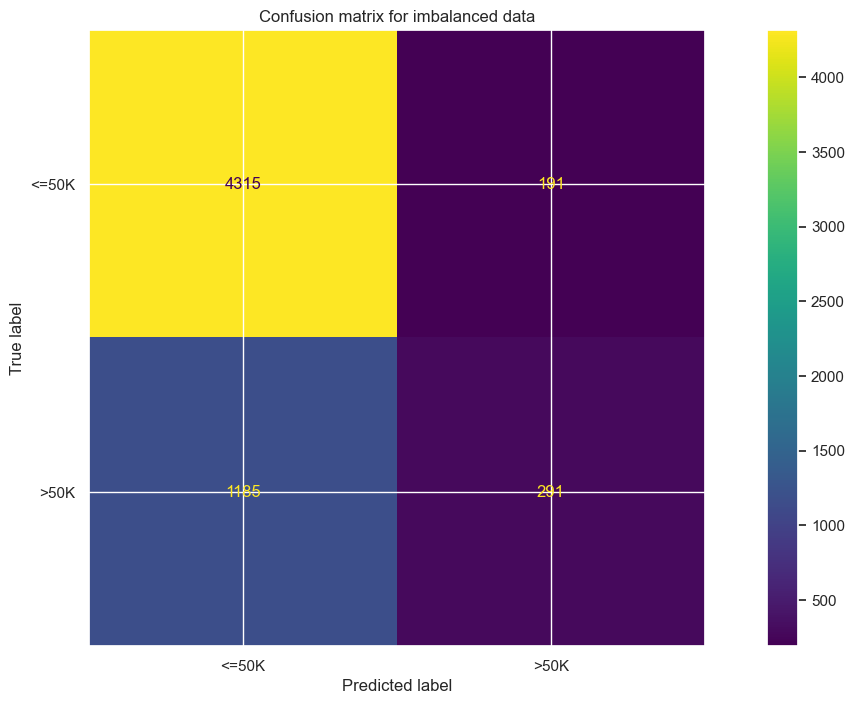

In [25]:
classification_lr(balance=True)